In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np 
from tqdm.auto import tqdm,trange
import multiprocessing
import time

In [24]:
class Environment():
    def __init__(self, arms: int, non_stationary: bool = False):
        self.arms = arms
        self.generate_starts()
        self.non_stationary = non_stationary

    def reset(self):
        self.generate_starts()

    def generate_starts(self):
        self.means = np.random.normal(0,1,arms)

    def step(self, action: int):
        reward = np.random.normal(self.means[action],1.0)

        if self.non_stationary: self.means += np.random.normal(0,0.01,arms)

        was_optimal = 1 if action in self.optimal_action() else 0

        return reward, was_optimal

    def optimal_action(self):
        return np.argwhere(self.means == np.amax(self.means)).flatten().tolist()


In [62]:
class Value_Function():
    def __init__(self, arms: int, initial_Qs = None):
        self.initial_Qs = initial_Qs
        self.Qs = np.zeros(arms,float) if self.initial_Qs is None else np.array(self.initial_Qs,copy=True)
        self.visit_ns = np.ones(arms,int)

    def reset(self):
        self.Qs = np.zeros(arms,float) if self.initial_Qs is None else np.array(self.initial_Qs,copy=True)
        self.visit_ns = np.ones(arms,int)
    
    def update(self, arm: int, reward: float, alpha: float):
        self.Qs[arm] = self.Qs[arm] + alpha * (reward - self.Qs[arm])
        self.visit_ns[arm]  += 1

    def get_values(self):
        return self.Qs

    def get_visits(self,arm):
        return self.visit_ns[arm]

    def get_rewards_over_time(self):
        return self.rewards_over_time

In [26]:
def get_action(arms: int, epsilon: float, value_function: Value_Function):
    if np.random.rand() < epsilon:
        return np.random.choice(range(arms))
    else:
        values = value_function.get_values()
        # return np.random.choice([action_ for action_,value_ in enumerate(values) if value_ == np.max(values)])
        return np.random.choice(np.where(np.max(values) == values)[0])

In [27]:
def generate_starts(arms):
    return np.random.normal(0,1,arms)

In [28]:
def alpha_generator(initial_alpha, value_n, alpha_type = "constant"):
    if alpha_type == "constant":
        return initial_alpha
    if alpha_type == "sample":
        return 1/value_n
    else:
        return 0.1

In [66]:
#HERE BE PARAMETERS

runs = 10000
steps = int(1e3)
arms = 10
initial_alpha = 0.1
random_walk = False

# alphas = ["constant","constant","constant","sample","sample","sample"]
# epsilons = [0.0,0.1,0.01,0.0,0.1,0.01]
# initial_Qs = np.zeros(arms,float)

alphas = ["constant","constant"]
epsilons = [0.0,0.1]
initial_Qs_list = [np.full((10),5.0),np.full((10),0.0)]


In [67]:
optimals = np.empty((len(alphas), runs, steps))
rewards = np.empty((len(alphas), runs, steps))
for i, (alphaChoice, epsilon, initial_Qs) in enumerate(zip(alphas,epsilons,initial_Qs_list)):
    environment = Environment(arms, random_walk)
    value_function = Value_Function(arms,initial_Qs)

    # rewards_over_time_all_runs = []
    # optimal_over_time_all_runs = []
    for r in tqdm(range(runs)):

        for s,step in enumerate(range(steps)):
            action = get_action(arms, epsilon, value_function)
            reward, was_optimal = environment.step(action)
            alpha = alpha_generator(initial_alpha, value_function.get_visits(action), alphaChoice)
            value_function.update(action, reward, alpha)

            optimals[i, r, s] = was_optimal
            rewards[i, r, s] = reward

        environment.reset()
        value_function.reset()

optimal_lines = optimals.mean(axis = 1)
rewards_lines = rewards.mean(axis = 1)



100%|██████████| 10000/10000 [08:10<00:00, 20.38it/s]


[array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


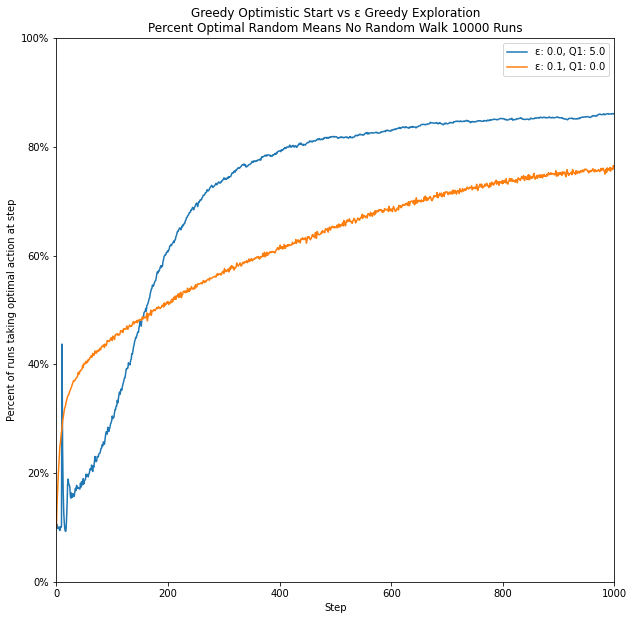

In [74]:
plt.figure(figsize=(10,10))
print(initial_Qs_list)
for optimals_i, optimals in enumerate(optimal_lines):
    plt.plot(optimals, label = "ε: " + str(epsilons[optimals_i]) + ", Q1: " + str(initial_Qs_list[optimals_i][0]))
plt.title("Greedy Optimistic Start vs ε Greedy Exploration\nPercent Optimal Random Means No Random Walk 10000 Runs")
plt.ylabel("Percent of runs taking optimal action at step")
plt.xlabel("Step")
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
# plt.savefig("../figures/exercise2-5/Greedy_Optimistic_Start_vs_ε_Greedy_Exploration_Percent_Optimal_Random_Means_10_arm_10000_Runs.png")

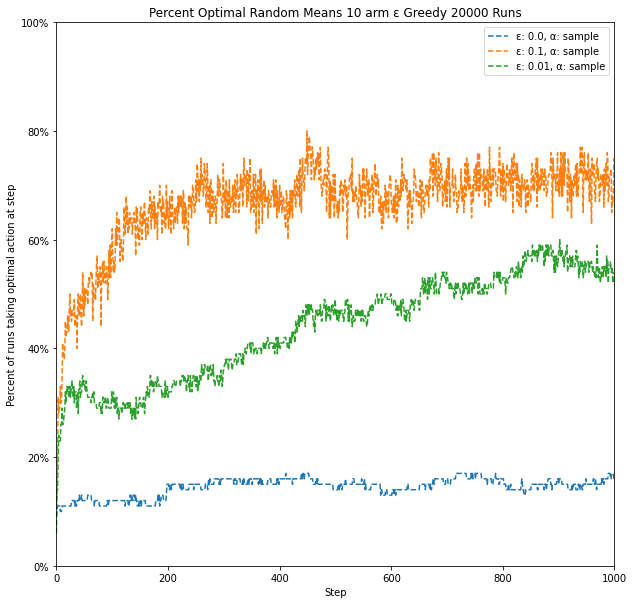

In [30]:
plt.figure(figsize=(10,10))
for optimals_i, optimals in enumerate(optimal_lines):
    plt.plot(optimals, label = "ε: " + str(epsilons[optimals_i]) + ", α: " + alphas[optimals_i], linestyle = "--" if alphas[optimals_i] == "sample" else "-")
plt.title("Percent Optimal Random Means 10 arm ε Greedy 20000 Runs")
plt.ylabel("Percent of runs taking optimal action at step")
plt.xlabel("Step")
plt.ylim(0,1.0)
plt.xlim(0,10000)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
# plt.savefig("../figures/exercise2-5/Percent_optimal_Random_Means_10_arm_ε_Greedy_20000_Runs.png")

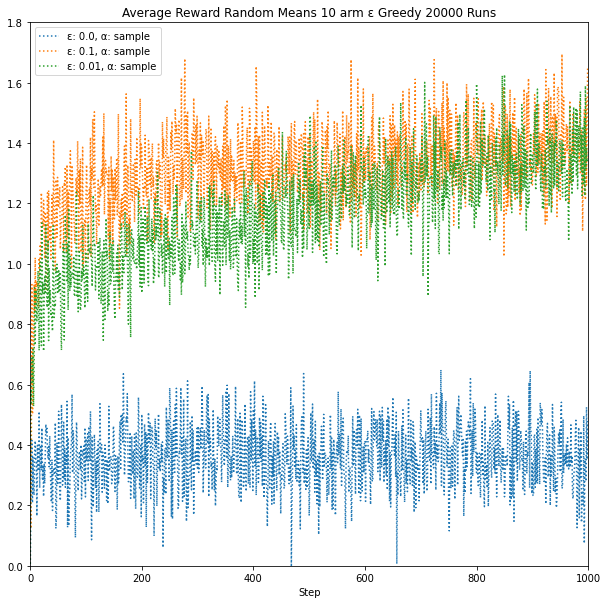

In [34]:
plt.figure(figsize=(10,10))
for rewards_i, rewards in enumerate(rewards_lines):
    plt.plot(rewards, label = "ε: " + str(epsilons[rewards_i]) + ", α: " + alphas[rewards_i], linestyle = "dotted" if alphas[rewards_i] == "sample" else "-")
plt.title("Average Reward Random Means 10 arm ε Greedy 20000 Runs")

plt.xlabel("Step")
plt.ylim(0,1.8)
plt.xlim(0,1000)
plt.legend()
# plt.savefig("../figures/exercise2-5/Average_Reward_Random_Means_10_arm_ε_Greedy_20000_Runs.png")